In [17]:
%pip install yfinance scikit-learn matplotlib pandas ipywidgets tqdm


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
from utils.SeriesProcessor import SeriesProcessor
from classes.frameworkDetector.framework_detector import FrameworkDetector

import numpy as np
import copy
from tqdm.notebook import tqdm
import time
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from utils import Visualizer
from utils.AuxiliaryFunctionFramework import AuxiliaryFunctionFramework
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from classes.detectores.ADWINDetector import ADWINDetector
from classes.detectores.DDMDetector import DDMDetector
from classes.detectores.EDDMDetector import EDDMDetector
from classes.detectores.FHDDMDetector import FHDDMDetector
from classes.detectores.HDDM_ADetector import HDDM_ADetector
from classes.detectores.PageHinkleyDetector import PageHinkleyDetector
from classes.detectores.HDDM_WDetector import HDDM_WDetector
from classes.detectores.KSWINDetector import KSWINDetector
from classes.modelosOffline.RandomForestModelo import RandomForestModelo # Para retreino

# **1. Preparação da Base de Dados**

In [19]:
# Lista de séries temporais disponíveis (para referência)
series = [
    "AAPL",
    "B3SA3.SA",
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

# Definindo parâmetros para processamento
lags = 5
serie_escolhida = series[-2]  # Exemplo: ^BVSP
print(f"Processando série: {serie_escolhida}")

# Baixando os dados
serie_temporal = SeriesProcessor.baixar_dados(serie_escolhida)

# Normalizando a série temporal
serie_temporal_normalizada = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal_normalizada.shape}")

# Gerando janelas temporais (features X e target Y)
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal_normalizada, lags)
print(f"Shape dos dados de entrada (X): {X.shape}")
print(f"Shape dos dados de saída (Y): {Y.shape}")

# Definindo tamanho do conjunto inicial de treinamento (por exemplo, 20% dos dados)
initial_size = int(0.2 * len(X))
print(f"Tamanho do conjunto inicial de treinamento: {initial_size} amostras")

# Dividindo os dados em conjunto inicial e streaming
X_init = X[:initial_size]
y_init = Y[:initial_size]
X_stream = X[initial_size:]
Y_stream = Y[initial_size:]

print(f"Shape do X_init: {X_init.shape}")
print(f"Shape do Y_init: {y_init.shape}")
print(f"Shape do X_stream: {X_stream.shape}")
print(f"Shape do Y_stream: {Y_stream.shape}")

# Alternativamente, você pode definir um número fixo de amostras iniciais
# Por exemplo, 100 primeiras amostras para treinamento
fixed_initial_size = 100
X_init_fixed = X[:fixed_initial_size]
Y_init_fixed = Y[:fixed_initial_size]
X_stream_fixed = X[fixed_initial_size:]
Y_stream_fixed = Y[fixed_initial_size:]

print("\nCom tamanho fixo:")
print(f"Shape do X_init_fixed: {X_init_fixed.shape}")
print(f"Shape do Y_init_fixed: {Y_init_fixed.shape}")
print(f"Shape do X_stream_fixed: {X_stream_fixed.shape}")
print(f"Shape do Y_stream_fixed: {Y_stream_fixed.shape}")

Processando série: ^BVSP


[*********************100%***********************]  1 of 1 completed

Shape da série após normalização: (1244, 1)
Shape dos dados de entrada (X): (1239, 5)
Shape dos dados de saída (Y): (1239, 1)
Tamanho do conjunto inicial de treinamento: 247 amostras
Shape do X_init: (247, 5)
Shape do Y_init: (247, 1)
Shape do X_stream: (992, 5)
Shape do Y_stream: (992, 1)

Com tamanho fixo:
Shape do X_init_fixed: (100, 5)
Shape do Y_init_fixed: (100, 1)
Shape do X_stream_fixed: (1139, 5)
Shape do Y_stream_fixed: (1139, 1)


In [20]:
# 2. Dados Reais de Séries Financeiras
def preparar_dados_financeiros(ticker="^BVSP", periodo="5y", lags=10):
    """Prepara dados de séries financeiras para experimentos"""
    print(f"Baixando dados para {ticker} nos últimos {periodo}...")

    # Baixar dados
    serie_temporal = SeriesProcessor.baixar_dados(ticker, periodo)

    # Pré-processamento
    serie_normalizada = SeriesProcessor.normalizar_serie(serie_temporal)

    # Criar janelas temporais
    X, y = SeriesProcessor.criar_janela_temporal(serie_normalizada, lags)

    print(f"Dados processados: {X.shape[0]} amostras com {X.shape[1]} features")

    return X, y, serie_temporal

# **2. Inicialização do Framework**

In [21]:
tamanho_janela = 200
intervalo_adicao_pool = 30
observacoes_novo_conceito = 75
detector_escolhido = "KSWIN"
tipo_modelo_inicial_global = RandomForestModelo

print("\n=== Inicialização do Framework ===")

# 1. Treinar Modelo Inicial e Obter Scaler
print(f"Treinando modelo inicial ({tipo_modelo_inicial_global.__name__}) com {len(X_init)} amostras...")

modelo_inicial, scaler = FrameworkDetector.treinar_modelo_inicial(X_init, y_init, tipo_modelo=tipo_modelo_inicial_global)

if modelo_inicial is None:
    raise RuntimeError("Falha crítica: Não foi possível treinar o modelo inicial.")

# 2. Inicializar Estado do Framework
modelo_atual = modelo_inicial
pool_modelos = [modelo_inicial]
print(f"\nModelo inicial ativo: {modelo_atual.nome if hasattr(modelo_atual, 'nome') else type(modelo_atual).__name__}")
print(f"Pool inicializado com 1 modelo.")

# 3. Inicializar Detector
print(f"Inicializando detector: {detector_escolhido}")
if detector_escolhido == "DDM":
    detector_wrapper = DDMDetector()
elif detector_escolhido == "ADWIN":
    detector_wrapper = ADWINDetector(delta=0.002)
elif detector_escolhido == "KSWIN":
    detector_wrapper = KSWINDetector(alpha=0.05, window_size=100)
elif detector_escolhido == "HDDM_W":
     detector_wrapper = HDDM_WDetector(drift_confidence=0.001, warning_confidence=0.005)
else:
    raise ValueError(f"Detector '{detector_escolhido}' não suportado ou não definido.")

# 4. Inicializar Janela e Contadores/Flags para a nova lógica
print(f"Inicializando janela de dados com as últimas {min(tamanho_janela, len(X_init))} amostras iniciais.")
janela_dados_recentes = list(zip(X_init[-tamanho_janela:], y_init[-tamanho_janela:]))
contador_adicao_pool = 0
drift_detectado_flag = False
contador_novo_conceito = 0
buffer_novo_conceito = []

# 5. Estruturas para armazenar resultados do stream
erros_predicao_stream = []
predicoes_stream = []
estados_detector_stream = []
pontos_drift_detectados = []
metricas_rmse_stream = []
metricas_mae_stream = []
metricas_r2_stream = []
modelo_ativo_ao_longo_do_tempo = []
tamanho_pool_ao_longo_do_tempo = []


=== Inicialização do Framework ===
Treinando modelo inicial (RandomForestModelo) com 247 amostras...
Ajustando Scaler nos dados iniciais...
✓ Scaler ajustado e aplicado.

Iniciando treinamento do modelo inicial: RandomForestModelo...


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


  ✅ Modelo RandomForestModelo treinado com sucesso

Modelo inicial ativo: RandomForestModelo
Pool inicializado com 1 modelo.
Inicializando detector: KSWIN
Inicializando janela de dados com as últimas 200 amostras iniciais.


# **3. Loop Principal de Detecção e Adaptação**

In [22]:
metrics_interval = 50
min_samples_for_metrics = 5

print("\n=== Iniciando Processamento do Stream ===")

print(f"Processando {len(X_stream)} amostras...")

start_time = time.time()

for i, (x_t, y_t) in enumerate(tqdm(zip(X_stream, Y_stream), total=len(X_stream), desc="Stream")):
    indice_global = initial_size + i

    # --- 1. Predição ---
    x_t_reshaped = x_t.reshape(1, -1)
    x_t_scaled = scaler.transform(x_t_reshaped)
    y_pred = modelo_atual.prever(x_t_scaled)[0]
    predicoes_stream.append(y_pred)

    # --- 2. Cálculo do Erro e Atualização do Detector ---
    erro = abs(y_t - y_pred)
    detector_wrapper.atualizar(erro)
    erros_predicao_stream.append(erro)

    # --- 3. Obter Estado do Detector ---
    estado = FrameworkDetector.get_state(detector_wrapper)
    estados_detector_stream.append(estado)

    # --- 4. Lógica de Adaptação Baseada no Estado e Flags ---

    # --- PASSO 4: Coletando dados para retreino após drift ---
    if drift_detectado_flag:
        contador_novo_conceito += 1
        buffer_novo_conceito.append((x_t, y_t))

        if contador_novo_conceito >= observacoes_novo_conceito:
            print(f"\n--- Retreinando Modelo ({tipo_modelo_inicial_global.__name__}) após {observacoes_novo_conceito} obs. do novo conceito ---")
            X_novo_list = [x for x, y in buffer_novo_conceito]
            y_novo_array = np.array([y for x, y in buffer_novo_conceito])

            novo_modelo = FrameworkDetector.treinar_novo_conceito(
                np.array(X_novo_list), y_novo_array, scaler, tipo_modelo=tipo_modelo_inicial_global
            )

            if novo_modelo:
                modelo_atual = novo_modelo
                pool_modelos = [modelo_atual]
                print(f"  ✓ Modelo atual substituído pelo modelo retreinado. Pool resetado para 1 modelo.")
            else:
                print(f"  ⚠️ Falha ao retreinar. Mantendo modelo atual ('{modelo_atual.nome if hasattr(modelo_atual, 'nome') else type(modelo_atual).__name__}'). Pool não resetado.")

            drift_detectado_flag = False
            contador_novo_conceito = 0
            buffer_novo_conceito = []
            contador_adicao_pool = 0
            print("--- Retomando operação normal ---")

    # --- Operação Normal / Detecção ---
    else:
        # --- PASSO 3: Mudança Detectada ---
        if estado == "MUDANÇA":
            pontos_drift_detectados.append(indice_global)
            print(f"\n!!! Drift detectado no índice global {indice_global} (Detector: {detector_escolhido}) !!!")
            print("  Iniciando avaliação do pool...")

            melhor_do_pool = FrameworkDetector.selecionar_melhor_modelo(pool_modelos, janela_dados_recentes, scaler)

            if melhor_do_pool:
                print(f"  ✓ Substituindo modelo atual pelo melhor do pool: '{melhor_do_pool.nome if hasattr(melhor_do_pool, 'nome') else type(melhor_do_pool).__name__}'")
                modelo_atual = melhor_do_pool
            else:
                print("  ⚠️ Não foi possível selecionar um modelo melhor do pool. Mantendo modelo atual.")

            drift_detectado_flag = True
            contador_novo_conceito = 0
            buffer_novo_conceito = [(x_t, y_t)]
            print(f"  Iniciando coleta de dados para retreino ({observacoes_novo_conceito} amostras necessárias).")

        # --- PASSO 2: Alerta Detectado ---
        elif estado == "ALERTA":
            if hasattr(modelo_atual, "partial_fit"):
                # Erro aqui interromperá o loop
                modelo_atual.partial_fit(x_t_scaled, np.array([y_t]))

        # --- PASSO 1: Estado Normal - Adição Periódica ao Pool ---
        elif estado == "NORMAL":
            contador_adicao_pool += 1
            if contador_adicao_pool >= intervalo_adicao_pool:
                print(f"\n  Adicionando cópia de '{modelo_atual.nome if hasattr(modelo_atual, 'nome') else type(modelo_atual).__name__}' ao pool (a cada {intervalo_adicao_pool} obs).")
                pool_modelos.append(copy.deepcopy(modelo_atual))
                contador_adicao_pool = 0
                print(f"  Tamanho do pool agora: {len(pool_modelos)}")


    # --- 5. Armazenar Resultados da Iteração ---
    modelo_ativo_ao_longo_do_tempo.append(modelo_atual.nome if hasattr(modelo_atual, 'nome') else type(modelo_atual).__name__)
    tamanho_pool_ao_longo_do_tempo.append(len(pool_modelos))

    # --- 6. Calcular Métricas Periodicamente ---
    if i > 0 and i % metrics_interval == 0 and len(janela_dados_recentes) >= min_samples_for_metrics:
        X_janela_eval = np.array([x for x, _ in janela_dados_recentes])
        y_janela_eval = np.array([y for _, y in janela_dados_recentes])
        X_janela_eval_scaled = scaler.transform(X_janela_eval)
        y_prev_eval = modelo_atual.prever(X_janela_eval_scaled)

        rmse = np.sqrt(mean_squared_error(y_janela_eval, y_prev_eval))
        mae = mean_absolute_error(y_janela_eval, y_prev_eval)
        r2 = r2_score(y_janela_eval, y_prev_eval)

        metricas_rmse_stream.append((indice_global, rmse))
        metricas_mae_stream.append((indice_global, mae))
        metricas_r2_stream.append((indice_global, r2))

    # --- 7. Atualizar Janela de Dados Recentes ---
    janela_dados_recentes = FrameworkDetector.adicionar_a_janela(
        janela_dados_recentes,
        (x_t, y_t),
        tamanho_max=tamanho_janela
    )

end_time = time.time()
print(f"\n=== Processamento do Stream Concluído ===")
print(f"Tempo total: {end_time - start_time:.2f} segundos")
print(f"Drifts detectados: {len(pontos_drift_detectados)}")
if pontos_drift_detectados:
    print(f"  Nos índices: {pontos_drift_detectados}")
print(f"Tamanho final do pool: {len(pool_modelos)}")


=== Iniciando Processamento do Stream ===
Processando 992 amostras...


Stream:   0%|          | 0/992 [00:00<?, ?it/s]


!!! Drift detectado no índice global 247 (Detector: KSWIN) !!!
  Iniciando avaliação do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0028)
  ✓ Substituindo modelo atual pelo melhor do pool: 'RandomForestModelo'
  Iniciando coleta de dados para retreino (75 amostras necessárias).

--- Retreinando Modelo (RandomForestModelo) após 75 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 76 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ✓ Modelo atual substituído pelo modelo retreinado. Pool resetado para 1 modelo.
--- Retomando operação normal ---

!!! Drift detectado no índice global 323 (Detector: KSWIN) !!!
  Iniciando avaliação do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.2527)
  ✓ Substituindo modelo atual pelo melhor do pool: 'RandomForestModelo

/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



--- Retreinando Modelo (RandomForestModelo) após 75 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 76 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ✓ Modelo atual substituído pelo modelo retreinado. Pool resetado para 1 modelo.
--- Retomando operação normal ---

!!! Drift detectado no índice global 399 (Detector: KSWIN) !!!
  Iniciando avaliação do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.1550)
  ✓ Substituindo modelo atual pelo melhor do pool: 'RandomForestModelo'
  Iniciando coleta de dados para retreino (75 amostras necessárias).


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



--- Retreinando Modelo (RandomForestModelo) após 75 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 76 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ✓ Modelo atual substituído pelo modelo retreinado. Pool resetado para 1 modelo.
--- Retomando operação normal ---

!!! Drift detectado no índice global 475 (Detector: KSWIN) !!!
  Iniciando avaliação do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0627)
  ✓ Substituindo modelo atual pelo melhor do pool: 'RandomForestModelo'
  Iniciando coleta de dados para retreino (75 amostras necessárias).


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



--- Retreinando Modelo (RandomForestModelo) após 75 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 76 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ✓ Modelo atual substituído pelo modelo retreinado. Pool resetado para 1 modelo.
--- Retomando operação normal ---

!!! Drift detectado no índice global 551 (Detector: KSWIN) !!!
  Iniciando avaliação do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0240)
  ✓ Substituindo modelo atual pelo melhor do pool: 'RandomForestModelo'
  Iniciando coleta de dados para retreino (75 amostras necessárias).


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



--- Retreinando Modelo (RandomForestModelo) após 75 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 76 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ✓ Modelo atual substituído pelo modelo retreinado. Pool resetado para 1 modelo.
--- Retomando operação normal ---

!!! Drift detectado no índice global 627 (Detector: KSWIN) !!!
  Iniciando avaliação do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0353)
  ✓ Substituindo modelo atual pelo melhor do pool: 'RandomForestModelo'
  Iniciando coleta de dados para retreino (75 amostras necessárias).


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



--- Retreinando Modelo (RandomForestModelo) após 75 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 76 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ✓ Modelo atual substituído pelo modelo retreinado. Pool resetado para 1 modelo.
--- Retomando operação normal ---

!!! Drift detectado no índice global 703 (Detector: KSWIN) !!!
  Iniciando avaliação do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0765)
  ✓ Substituindo modelo atual pelo melhor do pool: 'RandomForestModelo'
  Iniciando coleta de dados para retreino (75 amostras necessárias).


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



--- Retreinando Modelo (RandomForestModelo) após 75 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 76 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ✓ Modelo atual substituído pelo modelo retreinado. Pool resetado para 1 modelo.
--- Retomando operação normal ---

!!! Drift detectado no índice global 779 (Detector: KSWIN) !!!
  Iniciando avaliação do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0344)
  ✓ Substituindo modelo atual pelo melhor do pool: 'RandomForestModelo'
  Iniciando coleta de dados para retreino (75 amostras necessárias).


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



--- Retreinando Modelo (RandomForestModelo) após 75 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 76 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ✓ Modelo atual substituído pelo modelo retreinado. Pool resetado para 1 modelo.
--- Retomando operação normal ---

!!! Drift detectado no índice global 855 (Detector: KSWIN) !!!
  Iniciando avaliação do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.2792)
  ✓ Substituindo modelo atual pelo melhor do pool: 'RandomForestModelo'
  Iniciando coleta de dados para retreino (75 amostras necessárias).


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



--- Retreinando Modelo (RandomForestModelo) após 75 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 76 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ✓ Modelo atual substituído pelo modelo retreinado. Pool resetado para 1 modelo.
--- Retomando operação normal ---

!!! Drift detectado no índice global 931 (Detector: KSWIN) !!!
  Iniciando avaliação do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.1046)
  ✓ Substituindo modelo atual pelo melhor do pool: 'RandomForestModelo'
  Iniciando coleta de dados para retreino (75 amostras necessárias).


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



--- Retreinando Modelo (RandomForestModelo) após 75 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 76 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ✓ Modelo atual substituído pelo modelo retreinado. Pool resetado para 1 modelo.
--- Retomando operação normal ---

!!! Drift detectado no índice global 1007 (Detector: KSWIN) !!!
  Iniciando avaliação do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.2277)
  ✓ Substituindo modelo atual pelo melhor do pool: 'RandomForestModelo'
  Iniciando coleta de dados para retreino (75 amostras necessárias).


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



--- Retreinando Modelo (RandomForestModelo) após 75 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 76 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ✓ Modelo atual substituído pelo modelo retreinado. Pool resetado para 1 modelo.
--- Retomando operação normal ---

!!! Drift detectado no índice global 1083 (Detector: KSWIN) !!!
  Iniciando avaliação do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0092)
  ✓ Substituindo modelo atual pelo melhor do pool: 'RandomForestModelo'
  Iniciando coleta de dados para retreino (75 amostras necessárias).


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



--- Retreinando Modelo (RandomForestModelo) após 75 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 76 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ✓ Modelo atual substituído pelo modelo retreinado. Pool resetado para 1 modelo.
--- Retomando operação normal ---

!!! Drift detectado no índice global 1159 (Detector: KSWIN) !!!
  Iniciando avaliação do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0098)
  ✓ Substituindo modelo atual pelo melhor do pool: 'RandomForestModelo'
  Iniciando coleta de dados para retreino (75 amostras necessárias).


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



--- Retreinando Modelo (RandomForestModelo) após 75 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 76 amostras do novo conceito...
  ✅ Novo modelo (RandomForestModelo) treinado com sucesso.
  ✓ Modelo atual substituído pelo modelo retreinado. Pool resetado para 1 modelo.
--- Retomando operação normal ---

!!! Drift detectado no índice global 1235 (Detector: KSWIN) !!!
  Iniciando avaliação do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0227)
  ✓ Substituindo modelo atual pelo melhor do pool: 'RandomForestModelo'
  Iniciando coleta de dados para retreino (75 amostras necessárias).

=== Processamento do Stream Concluído ===
Tempo total: 10.90 segundos
Drifts detectados: 14
  Nos índices: [247, 323, 399, 475, 551, 627, 703, 779, 855, 931, 1007, 1083, 1159, 1235]
Tamanho final do pool: 1


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# **4. Análise e Visualização dos Resultados**


=== Análise dos Resultados do Stream ===


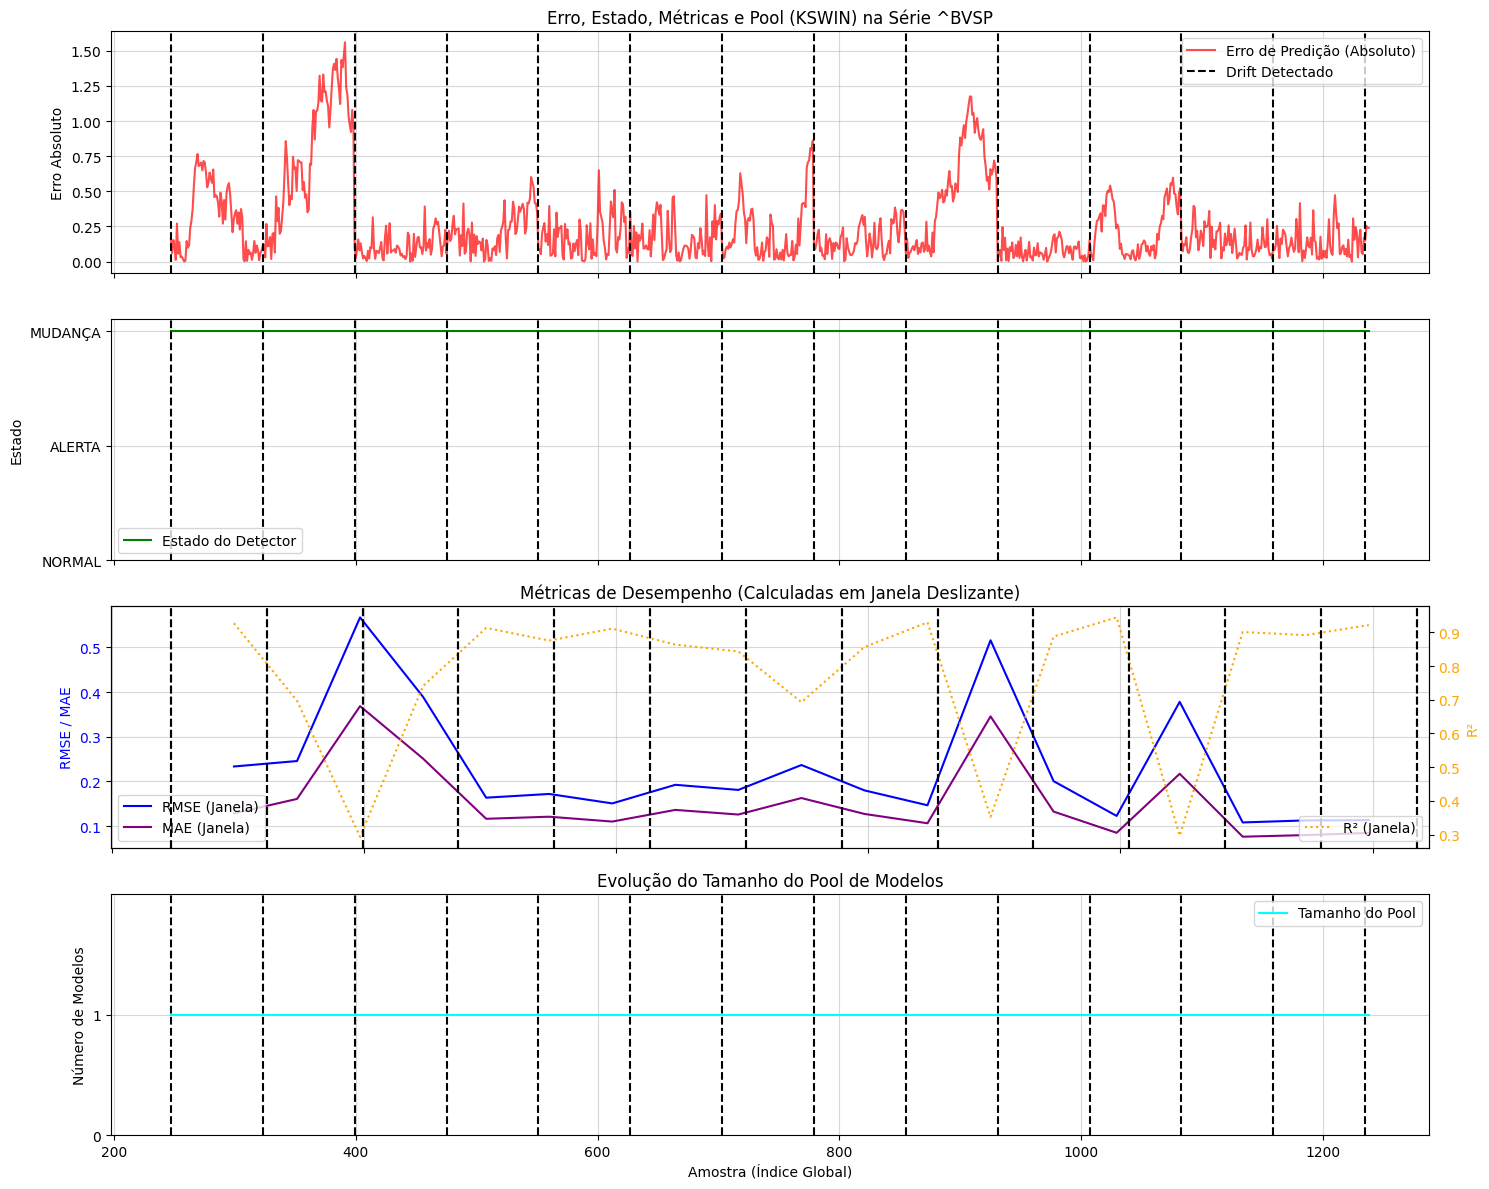


Métricas Globais no Stream:
  MSE: 0.1374
  MAE: 0.2488

Contagem de Uso dos Modelos Durante o Stream:
RandomForestModelo    992
Name: count, dtype: int64


In [23]:
Visualizer.analisar_e_visualizar_resultados_stream(
    initial_size=initial_size,
    erros_predicao_stream=erros_predicao_stream,
    estados_detector_stream=estados_detector_stream,
    pontos_drift_detectados=pontos_drift_detectados,
    metricas_rmse_stream=metricas_rmse_stream,
    metricas_mae_stream=metricas_mae_stream,
    metricas_r2_stream=metricas_r2_stream,
    modelo_ativo_ao_longo_do_tempo=modelo_ativo_ao_longo_do_tempo,
    tamanho_pool_ao_longo_do_tempo=tamanho_pool_ao_longo_do_tempo,
    detector_escolhido=detector_escolhido,
    serie_escolhida=serie_escolhida
)


=== Visualização: Valores Reais vs. Previsões ===


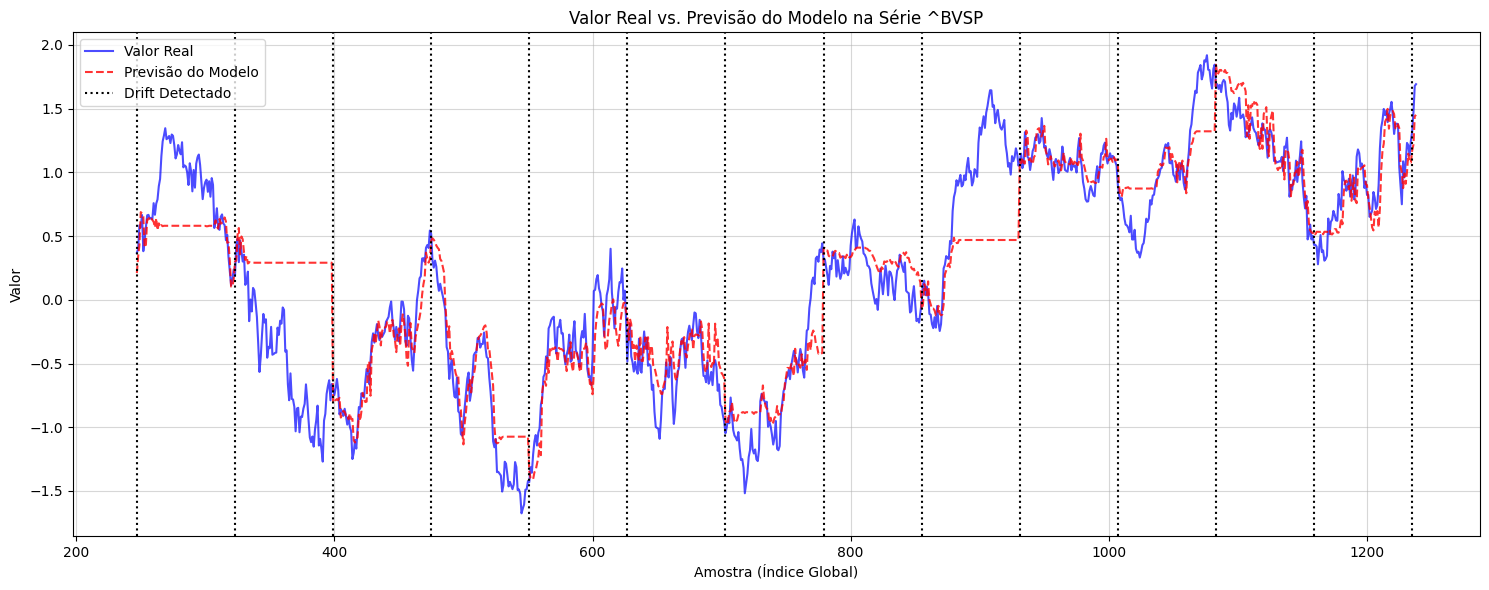

In [24]:
Visualizer.visualizar_previsoes_vs_real(
    initial_size=initial_size,
    Y_stream=Y_stream,
    predicoes_stream=predicoes_stream,
    pontos_drift_detectados=pontos_drift_detectados,
    serie_escolhida=serie_escolhida
)